In [2]:
!pip install transformers datasets torch scikit-learn pandas -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

<Axes: >

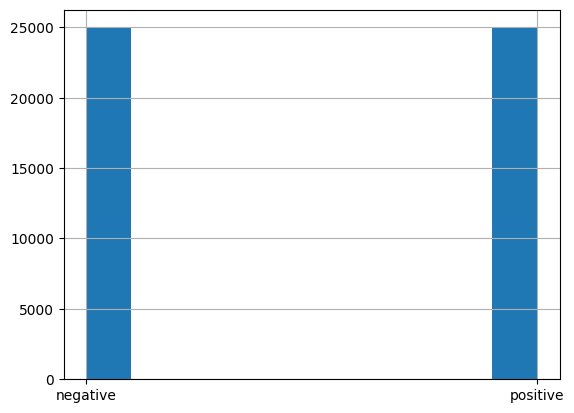

In [19]:
from datasets import load_dataset, Dataset
import numpy as np
import pandas as pd

# data prep
df = pd.read_csv('/content/skytrax_reviews.csv', index_col=0, sep=';', encoding='utf-8')

# map to Sentiment to binary label
df['Sentiment'].hist()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 6193 to 28216
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   rating        50000 non-null  int64 
 1   review_title  50000 non-null  object
 2   review_text   50000 non-null  object
 3   airline_name  50000 non-null  object
 4   Sentiment     50000 non-null  object
 5   label         50000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.7+ MB


In [10]:
df['label'] = df['Sentiment'].map({'negative': 0, 'positive': 1})

In [11]:
# Ensure labels are integers
df["label"] = df["label"].astype(int)

In [14]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

# Train-test split (66% train, 33% test)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["review_text"].tolist(), df["label"].tolist(), test_size=0.33, random_state=42
)

In [16]:
# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
test_dataset = Dataset.from_dict({"text": test_texts, "label": test_labels})

In [17]:
# Load model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [20]:
from transformers import DataCollatorWithPadding

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

# Tokenize datasets
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/33500 [00:00<?, ? examples/s]

Map:   0%|          | 0/16500 [00:00<?, ? examples/s]

In [24]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metric(eval_pred):
    """F1-Score, Accuracy, and Recall"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro")
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [27]:
from transformers import TrainingArguments, Trainer

# Parameter tuning
training_args = TrainingArguments(
    "model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
    report_to="none"
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metric,
)

# Train the model
trainer.train()

<ipython-input-27-c86718219f4d>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.207600
1000,0.145800
1500,0.122900
2000,0.108500
2500,0.075900
3000,0.066100
3500,0.064300
4000,0.062600


TrainOutput(global_step=4188, training_loss=0.10560667093526555, metrics={'train_runtime': 1097.0389, 'train_samples_per_second': 61.073, 'train_steps_per_second': 3.818, 'total_flos': 1.444419260605872e+16, 'train_loss': 0.10560667093526555, 'epoch': 2.0})

In [28]:
trainer.evaluate()

{'eval_loss': 0.1330869346857071,
 'eval_accuracy': 0.9675151515151516,
 'eval_precision': 0.9675419197625268,
 'eval_recall': 0.9675108429911375,
 'eval_f1': 0.9675144255565292,
 'eval_runtime': 89.266,
 'eval_samples_per_second': 184.841,
 'eval_steps_per_second': 11.561,
 'epoch': 2.0}